# TUNet TL Exp 2

In [1]:
'''
IMPORTS
'''
import tensorflow as tf
from tensorflow.image import resize, ResizeMethod

import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import random
import os
import time
from numpy import load
import numpy as np
import matplotlib.pyplot as plt

'''
DATA PATHS
'''
TOP_DIR = '/tf/Notebooks/Iwashita'

TRAIN_DIR = TOP_DIR + '/Data/Preprocessed_wAugmentation/Experiment2/Train'
VAL_DIR = TOP_DIR + '/Data/Preprocessed_wAugmentation/Experiment2/Validate'
TEST_DIR = TOP_DIR + '/Data/Preprocessed_wAugmentation/Experiment2/Test'

'''
OUTPUTS PATH
'''
WEIGHTS_PATH = TOP_DIR + '/Output/Weights/'
METRICS_PATH = TOP_DIR + '/Output/Metrics/'

'''
GPU
'''
gpu_p40 = '/device:GPU:1'
gpu_1660 = '/device:GPU:0'

!nvidia-smi

'''
TRAINING DATA
'''
print(TRAIN_DIR)
!cd /tf/Notebooks/Iwashita/Data/Preprocessed_wAugmentation/Experiment2/Train && ls

exp2_rgb_X_train = load(TRAIN_DIR + '/exp2_rgb_X_train.npy')
exp2_ir_X_train = load(TRAIN_DIR + '/exp2_ir_X_train.npy')
exp2_y_train = load(TRAIN_DIR + '/exp2_y_train.npy')

'''
VALIDATION DATA
'''
exp2_rgb_X_val = load(VAL_DIR + '/exp2_rgb_X_val.npy')
exp2_ir_X_val = load(VAL_DIR + '/exp2_ir_X_val.npy')
exp2_y_val =load(VAL_DIR + '/exp2_y_val.npy')

'''
TEST DATA
'''
exp2_rgb_X_test = load(TEST_DIR + '/exp2_rgb_X_test.npy')
exp2_ir_X_test = load(TEST_DIR + '/exp2_ir_X_test.npy')
exp2_y_test =load(TEST_DIR + '/exp2_y_test.npy')

'''
INTERSECTION OVER UNION
'''
def iou(y_true, y_pred, num_classes):
    intersection = np.histogram2d(y_true.flatten(), y_pred.flatten(), bins=num_classes)[0]
    area_true = np.histogram(y_true, bins=num_classes)[0]
    area_pred = np.histogram(y_pred, bins=num_classes)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    union = area_true + area_pred - intersection

    union[union == 0] = 1e-9
    iou = intersection / union

    return iou, np.mean(np.diag(iou))

'''
PIXEL ACCURACY
'''
def pixel_accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / y_true.size

'''
MEAN ACCURACY
'''
def mean_accuracy(y_true, y_pred, num_classes):
    intersection = np.histogram2d(y_true.flatten(), y_pred.flatten(), bins=num_classes)[0]
    area_true = np.histogram(y_true, bins=num_classes)[0]

    area_true[area_true == 0] = 1e-9
    accuracy = np.diag(intersection) / area_true

    return np.mean(accuracy)

'''
FREQUENCY-WEIGHTED INTERSECTION OVER UNION
'''
def fw_iou(y_true, y_pred, num_classes):
    intersection = np.histogram2d(y_true.flatten(), y_pred.flatten(), bins=num_classes)[0]
    area_true = np.histogram(y_true, bins=num_classes)[0]
    area_pred = np.histogram(y_pred, bins=num_classes)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    union = area_true + area_pred - intersection

    union[union == 0] = 1e-9
    iou = intersection / union
    fw_iou = np.sum(area_true * iou) / np.sum(area_true)

    return fw_iou

def display_one_hot_annotation(annotations_onehot):
    label = np.argmax(annotations_onehot, axis=-1)
    cmap = plt.get_cmap('tab10', 7)

    plt.imshow(label, cmap=cmap)
    plt.colorbar(ticks=range(num_classes), format=plt.FuncFormatter(lambda val, loc: {
        0: "unlabeled",
        1: "sand",
        2: "soil",
        3: "ballast",
        4: "rock",
        5: "bedrock",
        6: "rocky terrain"
    }[val]))
    plt.show()

print("Done")

2023-08-21 17:57:53.994241: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Mon Aug 21 17:57:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P40           Off  | 00000000:05:00.0 Off |                  Off |
| N/A   41C    P8    10W / 250W |      4MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:06:00.0  On |                  N/A |
| 44%   

In [2]:
'''
SPLITTIG DATA SETS INTO BLOCKS
'''

SPLIT = 2

'''
TRAINING DATA SPLIT
'''
exp2_rgb_X_train_split = np.array_split(exp2_rgb_X_train, SPLIT)
exp2_ir_X_train_split = np.array_split(exp2_ir_X_train, SPLIT)
exp2_y_train_split = np.array_split(exp2_y_train, SPLIT)

'''
VALIDATION DATA
'''
exp2_rgb_X_val_split = np.array_split(exp2_rgb_X_val, SPLIT)
exp2_ir_X_val_split = np.array_split(exp2_ir_X_val, SPLIT)
exp2_y_val_split = np.array_split(exp2_y_val, SPLIT)

print("Done")

Done


In [3]:
'''
MODEL PARAMS
'''
BATCH_SIZE = 2
EPOCHS = 1000 

LEARNING_RATE = 1e-4
PATIENCE = 15
FACTOR = 0.1

EXP2_FILENAME = "augmented_tunet_tl_split_exp2_batch{}_epoch{}_lr{}_p{}_f{}".format(
    BATCH_SIZE, EPOCHS, LEARNING_RATE, PATIENCE, FACTOR)

print("Done")

Done


### TUNet TL Common

In [4]:
'''
MODEL
'''
def ContractionPath(inputs, _padding='same', _activation='relu'):
    c1 = Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.25)(p1)

    c2 = Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.5)(p2)

    c3 = Conv2D(256, (3, 3), activation="relu", padding="same")(p2)
    c3 = Conv2D(256, (3, 3), activation="relu", padding="same")(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.5)(p3)

    c4 = Conv2D(512, (3, 3), activation="relu", padding="same")(p3)
    c4 = Conv2D(512, (3, 3), activation="relu", padding="same")(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.5)(p4)
    
    '''
    RETURN
    '''
    return c1, c2, c3, c4, p4

def ExpansionPath(c1, c2, c3, c4, p4, _padding='same', _activation='relu'):    
    cm = Conv2D(1024, (3, 3), activation="relu", padding="same")(p4)
    cm = Conv2D(1024, (3, 3), activation="relu", padding="same")(cm)
    
    deconv4 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding="same")(cm)
    c4 = resize(c4, (deconv4.shape[1], deconv4.shape[2]), method=ResizeMethod.BILINEAR)
    uconv4 = concatenate([deconv4, c4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(512, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(512, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same")(uconv4)
    c3 = resize(c3, (deconv3.shape[1], deconv3.shape[2]), method=ResizeMethod.BILINEAR)
    uconv3 = concatenate([deconv3, c3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(256, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(256, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same")(uconv3)
    c2 = resize(c2, (deconv2.shape[1], deconv2.shape[2]), method=ResizeMethod.BILINEAR)
    uconv2 = concatenate([deconv2, c2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(128, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(128, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(uconv2)
    c1 = resize(c1, (deconv1.shape[1], deconv1.shape[2]), method=ResizeMethod.BILINEAR)
    uconv1 = concatenate([deconv1, c1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(64, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(64, (3, 3), activation="relu", padding="same")(uconv1)
    
    return uconv1

def TUNet_TL():
    '''
    INPUT
    '''
    # Expected inputs are an RGB and an IR image
    input_rgb = Input((572, 572, 3))
    input_ir = Input((572, 572))
    input_ir = tf.expand_dims(input_ir, axis=-1)
    
    '''
    CONTRACTION PATH
    '''
    c1_rgb, c2_rgb, c3_rgb, c4_rgb, p4_rgb = ContractionPath(input_rgb)
    c1_ir, c2_ir, c3_ir, c4_ir, p4_ir = ContractionPath(input_ir)
    
    '''
    EXPANSION PATH
    '''
    cout_rgb = ExpansionPath(c1_rgb, c2_rgb, c3_rgb, c4_rgb, p4_rgb)
    cout_ir = ExpansionPath(c1_ir, c2_ir, c3_ir, c4_ir, p4_ir)
    
    cout_cat = concatenate([cout_rgb, cout_ir], axis=-1)

    '''
    OUTPUT
    '''
    softmax_output = Conv2D(7, (1, 1), padding="same", activation='softmax')(cout_cat)
    softmax_output = resize(softmax_output, (572, 572), method=ResizeMethod.BILINEAR)

    '''
    RETURN
    '''
    return Model(inputs=[input_rgb, input_ir], outputs=softmax_output)

'''
TRAIN
'''
def TUNet_Train(model, weights_filename, 
               X_rgb_train, X_ir_train, y_train, 
               X_rgb_val, X_ir_val, y_val):

    try:
        with tf.device(gpu_p40):
            
            model.compile(
                optimizer=Adam(learning_rate=LEARNING_RATE), 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

            callbacks = [
                ModelCheckpoint(weights_filename, save_best_only=True, save_weights_only=True, verbose=1),
                EarlyStopping(patience=PATIENCE, verbose=1),
                ReduceLROnPlateau(factor=FACTOR, patience=PATIENCE, min_lr=LEARNING_RATE, verbose=1)]
                
            for i in range(SPLIT):
                
                print("\n====== Batch " + repr(i+1) + " ======\n")
                
                history = model.fit(
                    [X_rgb_train[i], X_ir_train[i]], y_train[i],
                    validation_data=([X_rgb_val[i], X_ir_val[i]], y_val[i]),
                    batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks, verbose=2)
        
    except RuntimeError as e:
        print(e)
        
'''
SCORE
'''
def TUNet_Score(model, weights_filename, metrics_filename, 
                X_rgb_test, X_ir_test, y_test):
    
    try:
        with tf.device(gpu_p40):
            model.load_weights(weights_filename)

            score = model.evaluate([X_rgb_test, X_ir_test], y_test, batch_size=2, verbose=1)

            print("Test loss:", score[0])
            print("Test accuracy:", score[1])

            with open(metrics_filename, "a") as f:
                f.write(f"\Test Loss: {score[0]}\n")
                f.write(f"\Test Accuracy: {score[1]}\n")
                
    except RuntimeError as e:
        print(e)

'''
PREDICT
'''
def TUNet_Predict(model, X_rgb_test, X_ir_test):
    try:
        with tf.device(gpu_p40):
            pred = model.predict([X_rgb_test, X_ir_test], batch_size=2)
            
    except RuntimeError as e:
        print(e)
        
    return pred

'''
DISPLAY RANDOM RESULT
'''
def TUNet_Display(X_rgb_test, X_ir_test, y_test, y_pred):
    fig, axes = plt.subplots(1, 4, figsize=(10, 6))
    n = random.randint(0, len(X_rgb_test)-1)
    cmap = plt.get_cmap('tab10', 7)
    
    axes[0].imshow(X_rgb_test[n])
    axes[1].imshow(X_ir_test[n], cmap='gray')
    axes[2].imshow(np.argmax(y_test[n], axis=-1), cmap=cmap)
    axes[3].imshow(np.argmax(y_pred[n], axis=-1), cmap=cmap)
                                           
    axes[0].set_title("RGB")
    axes[1].set_title("IR")
    axes[2].set_title("Annotation")
    axes[3].set_title("Predicted")
    
    for ax in axes.flatten():
        ax.axis("off")
        
    plt.tight_layout()
    plt.show()
        
'''
CALCULATE METRICS
'''
def TUNet_Metrics(y_test, y_pred, metrics_filename):
    y_pred_classes = np.argmax(y_pred, axis=-1)
    y_true_classes = np.argmax(y_test, axis=-1)
    
    num_classes = 7
    
    iou_values, mean_iou = iou(y_true_classes, y_pred_classes, num_classes)
    pixel_acc = pixel_accuracy(y_true_classes, y_pred_classes)
    mean_acc = mean_accuracy(y_true_classes, y_pred_classes, num_classes)
    fw_iou_value = fw_iou(y_true_classes, y_pred_classes, num_classes)
    
    print(f"Mean IoU: {mean_iou}")
    print(f"Pixel accuracy: {pixel_acc}")
    print(f"Mean accuracy: {mean_acc}")
    print(f"Frequency-Weighted IoU: {fw_iou_value}")
    
    with open(metrics_filename, "a") as f:
        f.write("\nIoU Values:\n")
        
        for i, iou_val in enumerate(iou_values):
            f.write(f"Class {i}: {iou_val}\n")
        f.write(f"\nMean IoU: {mean_iou}\n")
        f.write(f"Pixel Accuracy: {pixel_acc}\n")
        f.write(f"Mean Accuracy: {mean_acc}\n")
        f.write(f"Frequency Weighted IoU: {fw_iou_value}\n")
    
print("Done")

Done


In [6]:
try:
    with tf.device(gpu_p40):
        exp2_model = TUNet_TL()
except RuntimeError as e:
    print(e)
    
print("Done")

Done


In [7]:
TUNet_Train(exp2_model, os.path.join(WEIGHTS_PATH, EXP2_FILENAME + '.h5'), 
                exp2_rgb_X_train_split, exp2_ir_X_train_split, exp2_y_train_split,
                exp2_rgb_X_val_split, exp2_ir_X_val_split, exp2_y_val_split)

print("Done")


====== Batch 1 ======

Epoch 1/1000


2023-08-21 17:58:28.089529: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-08-21 17:58:28.852533: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600



Epoch 1: val_loss improved from inf to 1.54343, saving model to /tf/Notebooks/Iwashita/Output/Weights/augmented_tunet_tl_split_exp2_batch2_epoch1000_lr0.0001_p15_f0.1.h5
124/124 - 150s - loss: 1.6415 - accuracy: 0.3231 - val_loss: 1.5434 - val_accuracy: 0.3739 - lr: 1.0000e-04 - 150s/epoch - 1s/step
Epoch 2/1000

Epoch 2: val_loss improved from 1.54343 to 1.50948, saving model to /tf/Notebooks/Iwashita/Output/Weights/augmented_tunet_tl_split_exp2_batch2_epoch1000_lr0.0001_p15_f0.1.h5
124/124 - 126s - loss: 1.5328 - accuracy: 0.3319 - val_loss: 1.5095 - val_accuracy: 0.3595 - lr: 1.0000e-04 - 126s/epoch - 1s/step
Epoch 3/1000

Epoch 3: val_loss improved from 1.50948 to 1.49409, saving model to /tf/Notebooks/Iwashita/Output/Weights/augmented_tunet_tl_split_exp2_batch2_epoch1000_lr0.0001_p15_f0.1.h5
124/124 - 126s - loss: 1.4798 - accuracy: 0.3870 - val_loss: 1.4941 - val_accuracy: 0.4242 - lr: 1.0000e-04 - 126s/epoch - 1s/step
Epoch 4/1000

Epoch 4: val_loss improved from 1.49409 to 1.4

Epoch 32/1000

Epoch 32: val_loss did not improve from 0.95373
124/124 - 124s - loss: 0.8700 - accuracy: 0.6784 - val_loss: 0.9616 - val_accuracy: 0.6413 - lr: 1.0000e-04 - 124s/epoch - 1000ms/step
Epoch 33/1000

Epoch 33: val_loss did not improve from 0.95373
124/124 - 124s - loss: 0.9031 - accuracy: 0.6589 - val_loss: 0.9602 - val_accuracy: 0.6349 - lr: 1.0000e-04 - 124s/epoch - 999ms/step
Epoch 34/1000

Epoch 34: val_loss improved from 0.95373 to 0.90764, saving model to /tf/Notebooks/Iwashita/Output/Weights/augmented_tunet_tl_split_exp2_batch2_epoch1000_lr0.0001_p15_f0.1.h5
124/124 - 125s - loss: 0.8209 - accuracy: 0.6962 - val_loss: 0.9076 - val_accuracy: 0.6637 - lr: 1.0000e-04 - 125s/epoch - 1s/step
Epoch 35/1000

Epoch 35: val_loss did not improve from 0.90764
124/124 - 124s - loss: 0.8525 - accuracy: 0.6841 - val_loss: 0.9962 - val_accuracy: 0.6281 - lr: 1.0000e-04 - 124s/epoch - 1s/step
Epoch 36/1000

Epoch 36: val_loss did not improve from 0.90764
124/124 - 124s - loss: 0.86

Epoch 69/1000

Epoch 69: val_loss did not improve from 0.60964
124/124 - 124s - loss: 0.5256 - accuracy: 0.8120 - val_loss: 0.7778 - val_accuracy: 0.7370 - lr: 1.0000e-04 - 124s/epoch - 1s/step
Epoch 70/1000

Epoch 70: val_loss did not improve from 0.60964
124/124 - 124s - loss: 0.4932 - accuracy: 0.8241 - val_loss: 0.6413 - val_accuracy: 0.7842 - lr: 1.0000e-04 - 124s/epoch - 1s/step
Epoch 71/1000

Epoch 71: val_loss did not improve from 0.60964
124/124 - 124s - loss: 0.4288 - accuracy: 0.8500 - val_loss: 0.9431 - val_accuracy: 0.6862 - lr: 1.0000e-04 - 124s/epoch - 1s/step
Epoch 72/1000

Epoch 72: val_loss improved from 0.60964 to 0.57618, saving model to /tf/Notebooks/Iwashita/Output/Weights/augmented_tunet_tl_split_exp2_batch2_epoch1000_lr0.0001_p15_f0.1.h5
124/124 - 125s - loss: 0.4760 - accuracy: 0.8276 - val_loss: 0.5762 - val_accuracy: 0.8049 - lr: 1.0000e-04 - 125s/epoch - 1s/step
Epoch 73/1000

Epoch 73: val_loss did not improve from 0.57618
124/124 - 124s - loss: 0.4417 - ac

Epoch 14/1000

Epoch 14: val_loss did not improve from 0.46826
124/124 - 124s - loss: 0.3049 - accuracy: 0.8925 - val_loss: 0.5465 - val_accuracy: 0.8153 - lr: 1.0000e-04 - 124s/epoch - 1s/step
Epoch 15/1000

Epoch 15: val_loss did not improve from 0.46826
124/124 - 124s - loss: 0.2961 - accuracy: 0.8951 - val_loss: 0.5822 - val_accuracy: 0.7992 - lr: 1.0000e-04 - 124s/epoch - 1s/step
Epoch 16/1000

Epoch 16: val_loss did not improve from 0.46826
124/124 - 124s - loss: 0.2864 - accuracy: 0.8994 - val_loss: 0.5320 - val_accuracy: 0.8246 - lr: 1.0000e-04 - 124s/epoch - 1s/step
Epoch 17/1000

Epoch 17: val_loss did not improve from 0.46826
124/124 - 124s - loss: 0.2933 - accuracy: 0.8943 - val_loss: 0.5428 - val_accuracy: 0.8200 - lr: 1.0000e-04 - 124s/epoch - 1s/step
Epoch 18/1000

Epoch 18: val_loss did not improve from 0.46826
124/124 - 124s - loss: 0.2871 - accuracy: 0.8983 - val_loss: 0.6562 - val_accuracy: 0.8012 - lr: 1.0000e-04 - 124s/epoch - 1s/step
Epoch 19/1000

Epoch 19: val_l

In [8]:
score = TUNet_Score(
    exp2_model, 
    os.path.join(WEIGHTS_PATH, EXP2_FILENAME + '.h5'),
    os.path.join(METRICS_PATH, EXP2_FILENAME + '.txt'),
    exp2_rgb_X_test,
    exp2_ir_X_test,
    exp2_y_test)

124/124 [==============================] - 27s 217ms/step - loss: 0.4987 - accuracy: 0.8291
Test loss: 0.4986775815486908
Test accuracy: 0.8291277885437012


In [9]:
y_pred = TUNet_Predict(exp2_model, exp2_rgb_X_test, exp2_ir_X_test)

124/124 [==============================] - 27s 219ms/step


2023-08-21 22:20:04.529429: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2271965696 exceeds 10% of free system memory.


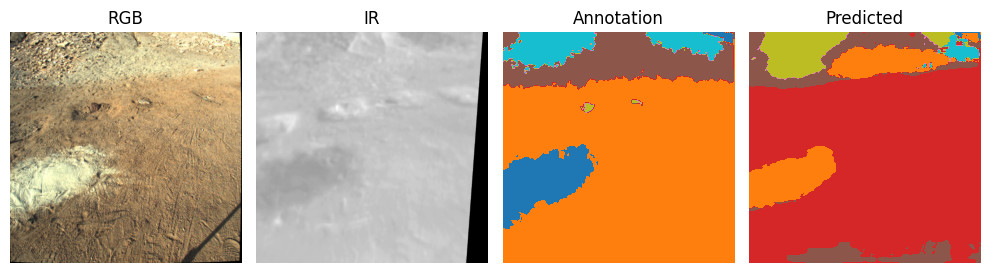

In [12]:
TUNet_Display(exp2_rgb_X_test, exp2_ir_X_test, exp2_y_test, y_pred)

In [13]:
TUNet_Metrics(exp2_y_test, y_pred, os.path.join(METRICS_PATH, EXP2_FILENAME + '.txt'))

Mean IoU: 0.6329715133567644
Pixel accuracy: 0.8291277035196926
Mean accuracy: 0.7543830116118315
Frequency-Weighted IoU: 0.7946527477905908
